In [5]:
import pandas as pd
import matplotlib.pyplot as plt
from collections import defaultdict

In [51]:
df = pd.read_csv('randomForest.csv')

In [75]:
scalar = df[df.type == 'scalar']
scalar = scalar[scalar['module'].str.contains("appl")]
scalar = scalar[['run','name','value']]
scalar.head()

,run,name,value
13987,General-110-20190306-12:47:47-5553,generatedWSMs,0.0
13988,General-110-20190306-12:47:47-5553,receivedWSMs,5142.0
13989,General-110-20190306-12:47:47-5553,generatedBSMs,0.0
13990,General-110-20190306-12:47:47-5553,receivedBSMs,0.0
13991,General-110-20190306-12:47:47-5553,generatedWSAs,0.0


In [63]:
iteration_vars = df[(df.type=='runattr') & (df.attrname == 'iterationvarsf')]

In [67]:
iteration_vars.head()

,run,type,module,name,attrname,attrvalue,value
5,General-113-20190306-12:47:55-5553,runattr,NaN,NaN,iterationvarsf,"10,.5,150,2-",NaN
116,General-110-20190306-12:47:47-5553,runattr,NaN,NaN,iterationvarsf,"10,.5,100,1-",NaN
227,General-112-20190306-12:47:53-5553,runattr,NaN,NaN,iterationvarsf,"10,.5,150,1-",NaN
338,General-111-20190306-12:47:49-5553,runattr,NaN,NaN,iterationvarsf,"10,.5,100,2-",NaN
449,General-109-20190306-12:47:43-5553,runattr,NaN,NaN,iterationvarsf,"10,.5,50,2-",NaN


In [70]:
run_attrs_dict = defaultdict(list)
for index, row in iteration_vars.iterrows():
    run_attrs =  row['attrvalue']
    run_attrs_arr = run_attrs.split(',')
    run_attrs_dict['number_mcs'].append(run_attrs_arr[0])
    run_attrs_dict['expected_reliability'].append(run_attrs_arr[1])
    run_attrs_dict['computation_task'].append(run_attrs_arr[2])
    run_attrs_dict['replication_factor'].append(run_attrs_arr[3][:len(run_attrs_arr[3])-1])
    run_attrs_dict['run'].append(row['run'])
run_attrs_df = pd.DataFrame(run_attrs_dict)

In [76]:
run_attrs_df.head()

,number_mcs,expected_reliability,computation_task,replication_factor,run
0,10,.5,150,2,General-113-20190306-12:47:55-5553
1,10,.5,100,1,General-110-20190306-12:47:47-5553
2,10,.5,150,1,General-112-20190306-12:47:53-5553
3,10,.5,100,2,General-111-20190306-12:47:49-5553
4,10,.5,50,2,General-109-20190306-12:47:43-5553


In [78]:
final_df = scalar.join(run_attrs_df.set_index('run'), on='run')

In [80]:
final_df.head()

,run,name,value,number_mcs,expected_reliability,computation_task,replication_factor
13987,General-110-20190306-12:47:47-5553,generatedWSMs,0.0,10,.5,100,1
13988,General-110-20190306-12:47:47-5553,receivedWSMs,5142.0,10,.5,100,1
13989,General-110-20190306-12:47:47-5553,generatedBSMs,0.0,10,.5,100,1
13990,General-110-20190306-12:47:47-5553,receivedBSMs,0.0,10,.5,100,1
13991,General-110-20190306-12:47:47-5553,generatedWSAs,0.0,10,.5,100,1


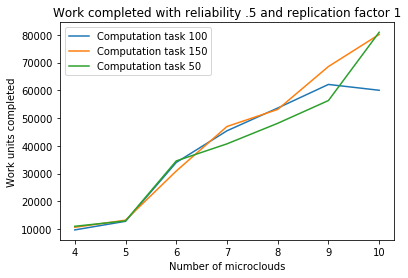

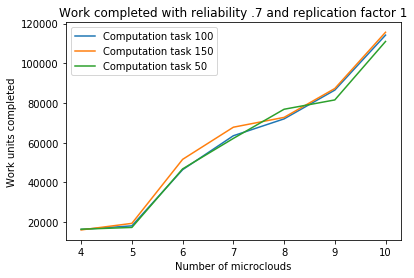

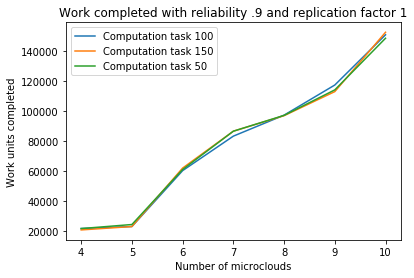

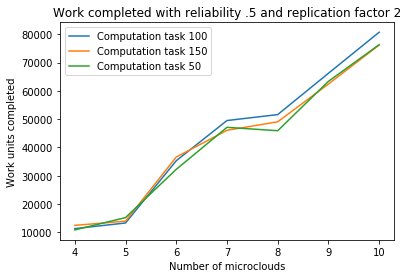

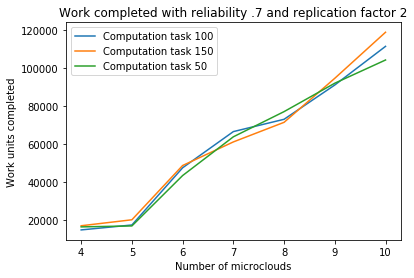

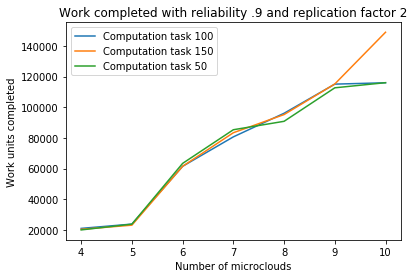

In [116]:
plot_work_to_num_mcs(final_df)

In [115]:
def plot_work_to_num_mcs(df):
    num_mc_values = final_df['number_mcs'].unique()
    num_mc_values = [int(num_mc) for num_mc in num_mc_values]
    num_mc_values.sort()
    num_mc_values = [str(num_mc) for num_mc in num_mc_values]
    er_values = df['expected_reliability'].unique()
    ct_values = df['computation_task'].unique()
    rf_values = df['replication_factor'].unique()
    for rf in rf_values:
        for er in er_values:
            for ct in ct_values:
                work = []
                num_mcs_arr = []
                for num_mc in num_mc_values:
                    tmp_df = df[df.number_mcs==num_mc]
                    tmp_df = tmp_df[tmp_df.name=='Load Balancer : 2 work finished']
                    tmp_df = tmp_df[(tmp_df.replication_factor==rf) & (tmp_df.computation_task==ct) &(tmp_df.expected_reliability==er)]
                    parsed_series =  tmp_df['value']
                    work.append(parsed_series[parsed_series.first_valid_index()])
                    num_mcs_arr.append(int(num_mc))
                plt.plot(num_mcs_arr,work,label="Computation task {}".format(ct))
            plt.xlabel("Number of microclouds")
            plt.ylabel("Work units completed")
            plt.title("Work completed with reliability {} and replication factor {}".format(er,rf))
            plt.legend(loc="best")
            plt.show()

In [ ]:
def plot_replication_factor(df):
    num_mc_values = df['number_mcs'].unique()
    er_values = df['expected_reliability'].unique()
    ct_values = df['computation_task'].unique()
    rf_values = df['replication_factor'].unique()
    lb = df[df.name=='Load Balancer : 2 work finished']
    for num_mc in num_mc_values:
        tmp_df = lb[lb.number_mcs ==num_mc]
        rf1,rf2,index = [],[],[]
        for ct in ct_values:
            for er in er_values:
                index.append("{},{}".format(ct,er))          
                for rf in rf_values:
                    tmp_df = tmp_df[(lb.replication_factor==rf) & (tmp_df.expected_reliability==er) & (tmp_df.computation_task ==ct)] 
                    parsed_series =  tmp_df['Unnamed: 18']
                    if rf=='1':
                        rf1.append(parsed_series[parsed_series.first_valid_index()])
                    else:
                        rf2.append(parsed_series[parsed_series.first_valid_index()])
        rf_df = pd.DataFrame({'replication factor of 1':rf1,'replication factor of 2':rf2},index=index)
        ax =rf_df.plot.bar(rot=0)
        ax.set_title(title)
        plt.show()